# 부정맥 (잘못된 리듬) on 심전도

In [1]:
# todo: 구글드라이브를 google.colab으로부터 연동해주세요
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# todo: 파일 경로를 확인하고, 뿌리경로 라는 이름의 주머니에 타이핑하여 지정해주세요
path_root = '/content/gdrive/MyDrive/proj/ecg/kaggle-mitbih'

# todo: 지정한 경로로 cd (change directory)
!cd /content/gdrive/MyDrive/proj/ecg/kaggle-mitbih

# todo: os를 import 하고 dir 정보를 list로 받아보세요
import os
type(os.listdir())

list

**INTRODUCTION**

심전도에서의 부정맥을 예측하고자 합니다.   
우리는 두 개의 서로 다른 데이터 세트가 있지만,   

mitbih. MIT-BIH 부정맥 데이터베이스에는 1975년과 1979년 사이에 BIH 부정맥 연구소에서 연구한 47명의 피험자로부터 얻은 2채널 보행 심전도 기록의 48시간 30분 발췌본이 포함되어 있습니다.  

  
보스턴의 베스 이스라엘 병원의 입원 환자(약 60%)와 외래 환자(약 40%)의 혼합 인구로부터 수집된 4000개의 24시간 보행 심전도 기록 세트에서 23개의 기록이 무작위로 선택되었다. 


데이터 수: 47명의 피험간  
측정 방식: 2채널 ECG  
데이터 형식: 4000개  

    
나머지 25개의 기록은 임상적으로 유의한 부정맥을 포함하기 위해 동일한 세트에서 선택. 
  
출처: https://physionet.org/content/mitdb/1.0.0/



48 half-hour excerpts of two-channel ambulatory ECG recordings,  
obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979.  

Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected 
from a mixed population of inpatients (about 60%) and outpatients (about 40%) 

at Boston's Beth Israel Hospital; 

the remaining 25 recordings were selected from the same set 

Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

-N : Normal 비트(정상 비트)
-S : 초심실외박동
-V : 심실외박동
-F : 퓨전 비트
-Q : 알 수없는 비트

-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**What is an ecg? **

심전도(ECG)는 심장의 박동과 전기 활동을 확인하는 데 사용될 수 있는 간단한 검사이다.

피부에 부착된 센서는 심장이 뛸 때마다 발생하는 전기 신호를 감지하는 데 사용됩니다.

이 신호들은 기계에 의해 기록되고 의사는 그것들이 특이한지 보기 위해 살펴봅니다.

심전도 검사는 심장 전문의(심장 전문의) 또는 GP를 포함하여 심장에 문제가 있을 수 있다고 생각하는 의사가 요청할 수 있습니다. 이것이 우리가 분석할 이 테스트의 결과입니다.

An electrocardiogram (ECG) may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.

**Load Data**

In [3]:
# todo: os를 불러오고 os에서 걸어다니며 가져올 대상은 (path_root)
# filenames 확인

In [4]:
path_dirfile_all = []
for dirname, _, filenames in os.walk(path_root):
  for filename in filenames:
    path_dirfile_all.append(os.path.join(dirname, filename))

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [6]:
# todo: path 전체에 대하여 idx_path가 for문으로 관찰읽어오기
# 만약 파일명에 'train'이 있으면 train_df에 읽어오기
# 또, 만약 파일명에 'test'가 있으면 test_df에 읽어오기

In [7]:
for idx_path in range(len(path_dirfile_all)):
  if 'train' in path_dirfile_all[idx_path]:
    train_df = pd.read_csv(path_dirfile_all[idx_path], header=None)
    print('path_dirfile_all[idx_path]', path_dirfile_all[idx_path])
  elif 'test' in path_dirfile_all[idx_path]:
    test_df = pd.read_csv(path_dirfile_all[idx_path], header=None)

path_dirfile_all[idx_path] /content/gdrive/MyDrive/proj/ecg/kaggle-mitbih/mitbih_train.csv


**Balance of dataset**

In [8]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [9]:
# train_df[187]은 레이블입니다. 0-4 

# todo:
# 레이블을 int형으로 타입을 변경하여 다시 원래 자리에 넣어주세요
# equilibre에 각 레이블의 값_숫자를 세어 기록해주세요

In [10]:
train_df[187] = train_df[187].astype(int)
equilibre = train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [11]:
# circle pie 그리기

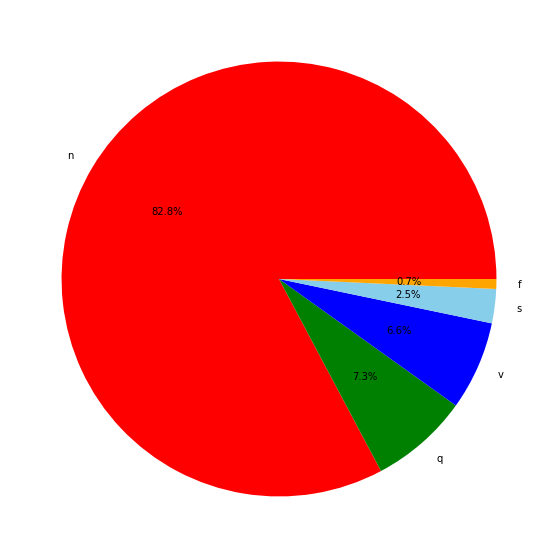

In [12]:
plt.figure(figsize=(20,10))
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
plt.show()

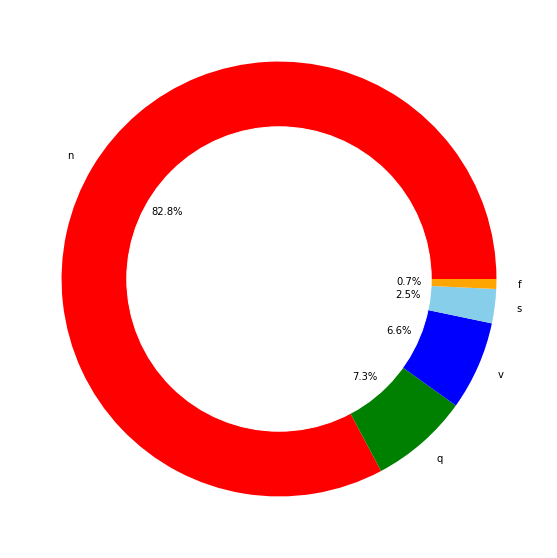

In [13]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.show()

클래스 가중치보다 리샘플 기법을 더 선택하기로 결정
decided to choose the resample technique

In [14]:
# todo: train_df[187]==0 인 인덱스에 대하여 샘플링을 n=20000, random_state=상수 (레이블마다 다르게) 진행
# 나머지 부족한 레이블에 대해서도, n=20000이 되도록 리샘플링 (= 숫자가 부족했으니, 추가되도록 업샘플링이라는 주머니 이름)

In [15]:
from sklearn.utils import resample

df_0 = train_df[train_df[187]==0].sample(n=20000, random_state=42)
df_1 = train_df[train_df[187]==1]
df_2 = train_df[train_df[187]==2]
df_3 = train_df[train_df[187]==3]
df_4 = train_df[train_df[187]==4]

df_1_upsample = resample(df_1, replace=True, n_samples=20000, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=20000, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=20000, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=20000, random_state=126)

train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [16]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


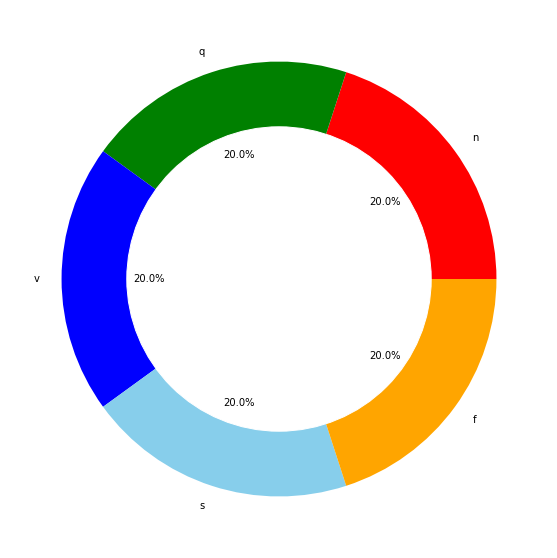

In [17]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Resample works perfectly we can go on. 

**Classes**

In [18]:
# todo: sample(1)으로 샘플하나 관찰하기
# class 약자인 c로 데이터 하나 체크
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1)) 
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
14290,0.965665,0.545064,0.072961,0.090129,0.133047,0.085837,0.064378,0.055794,0.038627,0.030043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72485,1.000000,0.903226,0.318548,0.108871,0.169355,0.254032,0.229839,0.258065,0.334677,0.310484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
80366,0.922607,0.881874,0.576375,0.289206,0.189409,0.173116,0.136456,0.132383,0.105906,0.109980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80599,0.878229,1.000000,0.940959,0.501845,0.260148,0.171587,0.143911,0.134686,0.108856,0.114391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85205,0.843750,0.430556,0.468750,0.465278,0.486111,0.486111,0.524306,0.486111,0.406250,0.277778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


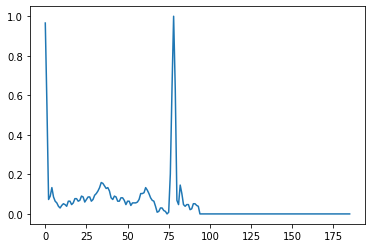

In [19]:
plt.plot(c.iloc[0,:186])

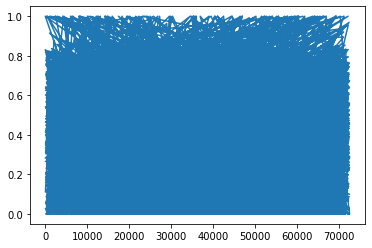

In [20]:
# todo: train_df.loc[train_df[187]==class_number_tmp]를 plot 해보세요
class_number_tmp = 0
img = train_df.loc[train_df[187]==class_number_tmp]

plt.plot(img[2])

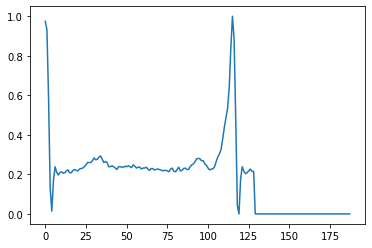

In [21]:
# todo: 조금 다르게, train_df.loc[train_df[187]==class_number_tmp].values를 plot
class_number_tmp = 0
img = train_df.loc[train_df[187]==class_number_tmp].values

plt.plot(img[2])

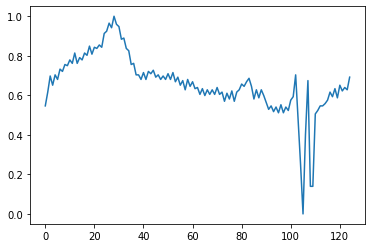

In [22]:
min_ = 5
size = 130
img_tmp=img[0,min_: size]

plt.plot(img_tmp)

In [23]:
# todo: img.flatten 선언하고, plot 해보세요


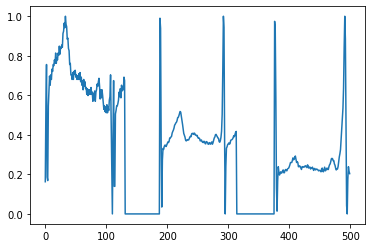

In [24]:
img_flatten=img.flatten()
plt.plot(img_flatten[:500])

In [25]:
# hist를 통해서 여러개 신호를 겹쳐서 살펴보겠습니다! size = plot 할 신호의 길이

class_number, np.shape(img) 0 (20000, 65)


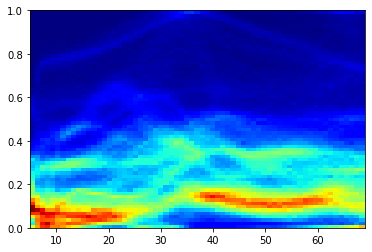

In [27]:
def plot_hist(class_number,size,min_,bins):
    img = train_df.loc[train_df[187]==class_number].values
    img = img[:,min_:size] # 5에서 70까지라, 65가 되기도함
    print('class_number, np.shape(img)', class_number, np.shape(img))

    # todo: hist2d에 들어갈 한데이터인 '이미지의 flatten' 모습
    img_flatten = img.flatten()

    final1 = np.arange(min_, size)

    for i in range(img.shape[0] - 1):
      tempo1 = np.arange(min_, size)
      final1 = np.concatenate((final1, tempo1), axis=None)

    # todo: hist2d에 대해 확인하고 적용해보겠습니다.
    # x의 값은 첫 번째 차원을 따라 히스토그램 화되고 y의 값은 두 번째 차원을 따라 히스토그램화됩니다.
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

plot_hist(0,70,5,65) # 클래스번호, 사이즈, 최소값, x축 (time) 몇개씩 나눠서 볼까요

각 클래스별 신호 모양 차이를 한번 체크해보겠습니다!

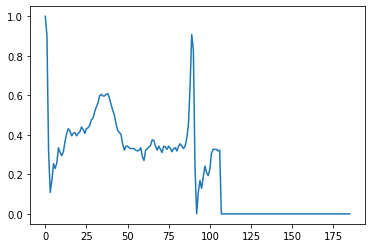

In [28]:
plt.plot(c.iloc[1,:186])

class_number, np.shape(img) 1 (20000, 45)


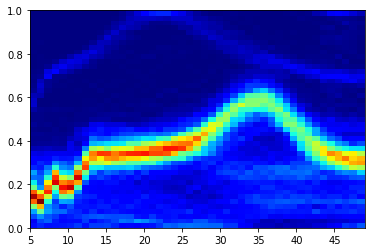

In [29]:
plot_hist(1,50,5,45)

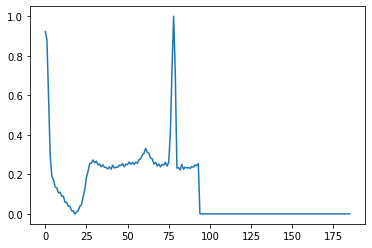

In [30]:
plt.plot(c.iloc[2,:186])

class_number, np.shape(img) 2 (20000, 45)


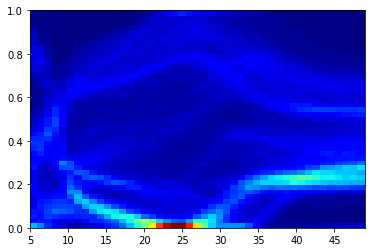

In [31]:
plot_hist(2,50,5,45)

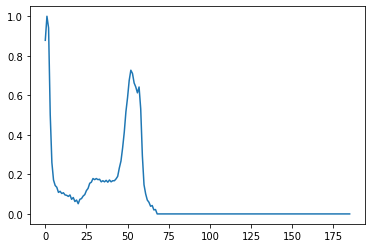

In [32]:
plt.plot(c.iloc[3,:186])

class_number, np.shape(img) 3 (20000, 45)


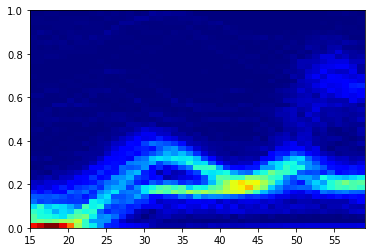

In [33]:
plot_hist(3,60,15,45)

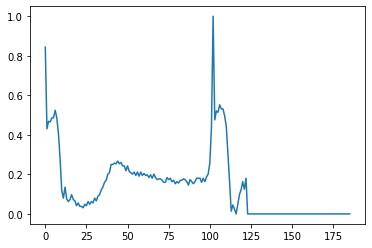

In [34]:
plt.plot(c.iloc[4,:186])

class_number, np.shape(img) 4 (20000, 35)


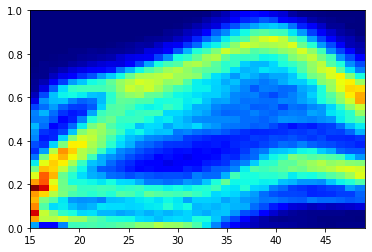

In [35]:
plot_hist(4,50,15,35)